# Long Short-Term Memory (LSTM) Networks

Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) designed to model sequential data and capture long-range dependencies. LSTMs address the vanishing and exploding gradient problems found in traditional RNNs by introducing a memory cell and gating mechanisms.

## LSTM Cell Structure

An LSTM cell consists of three main gates:

- **Forget Gate**: Decides what information to discard from the cell state.
- **Input Gate**: Decides which new information to store in the cell state.
- **Output Gate**: Decides what information to output.

## Mathematical Expressions

Given input vector $x_t$, previous hidden state $h_{t-1}$, and previous cell state $c_{t-1}$:

1. **Forget Gate**  
    $f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)$

2. **Input Gate**  
    $i_t = \sigma(W_i [h_{t-1}, x_t] + b_i)$  
    $\tilde{c}_t = \tanh(W_c [h_{t-1}, x_t] + b_c)$

3. **Cell State Update**  
    $c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$

4. **Output Gate**  
    $o_t = \sigma(W_o [h_{t-1}, x_t] + b_o)$  
    $h_t = o_t \odot \tanh(c_t)$

Where:  
- $\sigma$ is the sigmoid activation function.  
- $\tanh$ is the hyperbolic tangent activation function.  
- $\odot$ denotes element-wise multiplication.  
- $W_f, W_i, W_c, W_o$ are weight matrices.  
- $b_f, b_i, b_c, b_o$ are bias vectors.

## Summary

LSTMs maintain a cell state that is updated through carefully regulated gates, allowing the network to learn long-term dependencies in sequential data. This makes LSTMs highly effective for tasks such as language modeling, time series prediction, and sequence classification.


## **ARCHITECHTURE EXPAMPLE**

![LSTM](images/lstm.png)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import lightning as L
from torch.utils.data import TensorDataset, DataLoader


In [28]:
class LSTMbyHand(L.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)
        
        self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        
    def lstm_unit(self, input_value, long_memory, short_memory):
        
        long_remember_percent = torch.sigmoid((short_memory* self.wlr1)+(input_value*self.wlr2)+self.blr1)
        potential_remember_percent = torch.sigmoid((short_memory* self.wpr1)+(input_value*self.wpr2)+self.bpr1)
        potential_memory = torch.tanh((short_memory*self.wp1)+(input_value*self.wp2)+self.bp1)
        updated_long_memory = ((long_memory*long_remember_percent)+(potential_remember_percent*potential_memory))
        
        output_percent = torch.sigmoid((short_memory*self.wo1)+(input_value*self.wo2)+self.bo1)
        updated_short_memory = torch.tanh(updated_long_memory)*output_percent
        
        return [updated_long_memory , updated_short_memory]
    
    def forward(self, input):
        
        long_memory=0
        short_memory=0
        
        day1 = input[0]
        day2 = input[1]
        day3 = input[2]
        day4 = input[3]
        
        long_memory,short_memory = self.lstm_unit(day1, long_memory, short_memory)
        long_memory,short_memory = self.lstm_unit(day2, long_memory, short_memory)
        long_memory,short_memory = self.lstm_unit(day3, long_memory, short_memory)
        long_memory,short_memory = self.lstm_unit(day4, long_memory, short_memory)
        
        return short_memory
        
    def configure_optimizers(self):
        return Adam(self.parameters())
        
    def training_step(self, batch, batch_idx):
        input_i,label_i = batch
        output_i = self.forward(input_i[0])
        loss = (output_i -label_i)**2
        
        self.log("train_loss",loss)
        
        if(label_i == 0):
            self.log('out_0',output_i)
        else:
            self.log("out_1",output_i)
        return loss
        
        

In [29]:
model = LSTMbyHand()

In [30]:
print("\n Let's compare the observed and predicted values...")
print(f"\n Company A: observed = 0 ,predicted = {model(torch.tensor([0.,.5,.25,1.]).detach())}")
print(f"\n Company B: observed = 0 ,predicted = {model(torch.tensor([1.,.5,.25,1.]).detach())}")


 Let's compare the observed and predicted values...

 Company A: observed = 0 ,predicted = -0.28918588161468506

 Company B: observed = 0 ,predicted = -0.3002510070800781


In [31]:
inputs = torch.tensor([[0.,.5,.25,1.],[1.,.5,.25,1.]])

In [32]:
labels = torch.tensor([0.,1.])

In [33]:
dataset= TensorDataset(inputs,labels)
dataloader = DataLoader(dataset)

In [34]:
dataset,dataloader

(<torch.utils.data.dataset.TensorDataset at 0x145fa91d0>,
 <torch.utils.data.dataloader.DataLoader at 0x145fa9310>)

In [35]:
trainer = L.Trainer(max_epochs=2000)
trainer.fit(model, train_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 12     | n/a 
---------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/bishwashchaudhari/quests/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/bishwashchaudhari/quests/ve

Epoch 1999: 100%|██████████| 2/2 [00:00<00:00, 86.76it/s, v_num=6] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 2/2 [00:00<00:00, 59.96it/s, v_num=6]


In [36]:
print("\n Let's compare the observed and predicted values...")
print(f"\n Company A: observed = 0 ,predicted = {model(torch.tensor([0.,.5,.25,1.]).detach())}")
print(f"\n Company B: observed = 0 ,predicted = {model(torch.tensor([1.,.5,.25,1.]).detach())}")


 Let's compare the observed and predicted values...

 Company A: observed = 0 ,predicted = 0.5038868188858032

 Company B: observed = 0 ,predicted = 0.5145977735519409


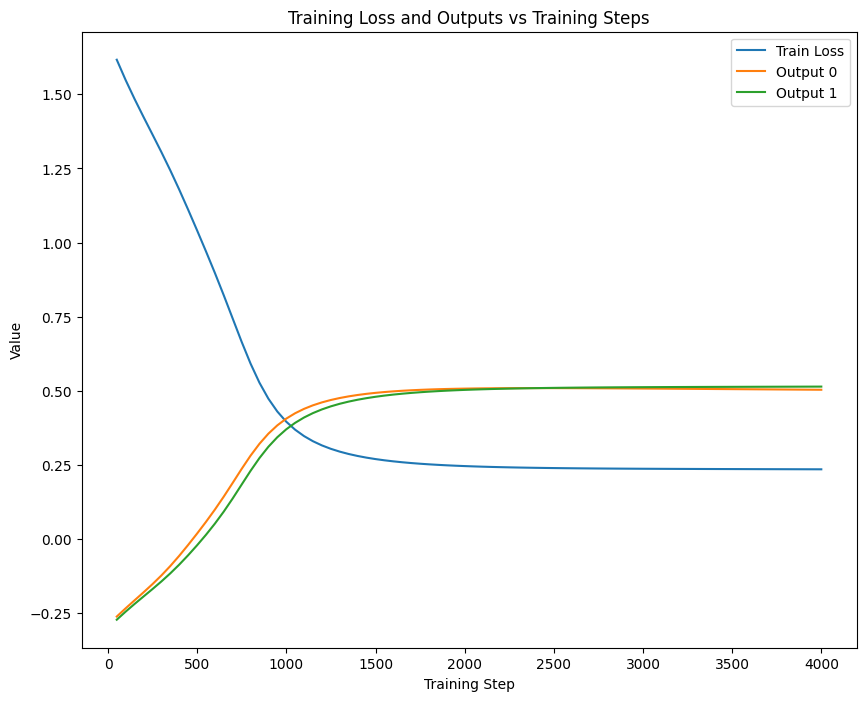

In [37]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import glob

log_dirs = sorted(glob.glob('lightning_logs/version_*'), key=lambda x: int(x.split('_')[-1]))
if log_dirs:
    log_dir = log_dirs[-1]
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Extract scalar data
    steps = []
    train_loss = []
    out_0 = []
    out_1 = []

    if 'train_loss' in ea.Tags()['scalars']:
        for e in ea.Scalars('train_loss'):
            steps.append(e.step)
            train_loss.append(e.value)
    if 'out_0' in ea.Tags()['scalars']:
        out_0 = [e.value for e in ea.Scalars('out_0')]
    if 'out_1' in ea.Tags()['scalars']:
        out_1 = [e.value for e in ea.Scalars('out_1')]

    plt.figure(figsize=(10,8))
    plt.plot(steps, train_loss, label='Train Loss')
    if out_0:
        plt.plot(steps[:len(out_0)], out_0, label='Output 0')
    if out_1:
        plt.plot(steps[:len(out_1)], out_1, label='Output 1')
    plt.xlabel('Training Step')
    plt.ylabel('Value')
    plt.title('Training Loss and Outputs vs Training Steps')
    plt.legend()
    plt.show()
else:
    print("No lightning_logs found. Please run training first.")

In [38]:
# Find the ModelCheckpoint callback and get the best model path
checkpoint_callback = None
for cb in trainer.callbacks:
	if hasattr(cb, "best_model_path"):
		checkpoint_callback = cb
		break

if checkpoint_callback is not None:
	path_to_best_checkpoint = checkpoint_callback.best_model_path
else:
	path_to_best_checkpoint = None  # or raise an error if you want

trainer = L.Trainer(max_epochs=5000)
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=path_to_best_checkpoint)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /Users/bishwashchaudhari/quests/lightning_logs/version_6/checkpoints/epoch=1999-step=4000.ckpt
/Users/bishwashchaudhari/quests/venv/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/Users/bishwashchaudhari/quests/lightning_logs/version_6/checkpoints' to '/Users/bishwashchaudhari/quests/lightning_logs/version_7/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 12     | n/a 
--

Epoch 4999: 100%|██████████| 2/2 [00:00<00:00, 73.33it/s, v_num=7] 

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 2/2 [00:00<00:00, 51.59it/s, v_num=7]


In [39]:
print("\n Let's compare the observed and predicted values...")
print(f"\n Company A: observed = 0 ,predicted = {model(torch.tensor([0.,.5,.25,1.]).detach())}")
print(f"\n Company B: observed = 0 ,predicted = {model(torch.tensor([1.,.5,.25,1.]).detach())}")


 Let's compare the observed and predicted values...

 Company A: observed = 0 ,predicted = 0.05252685025334358

 Company B: observed = 0 ,predicted = 0.8376198410987854


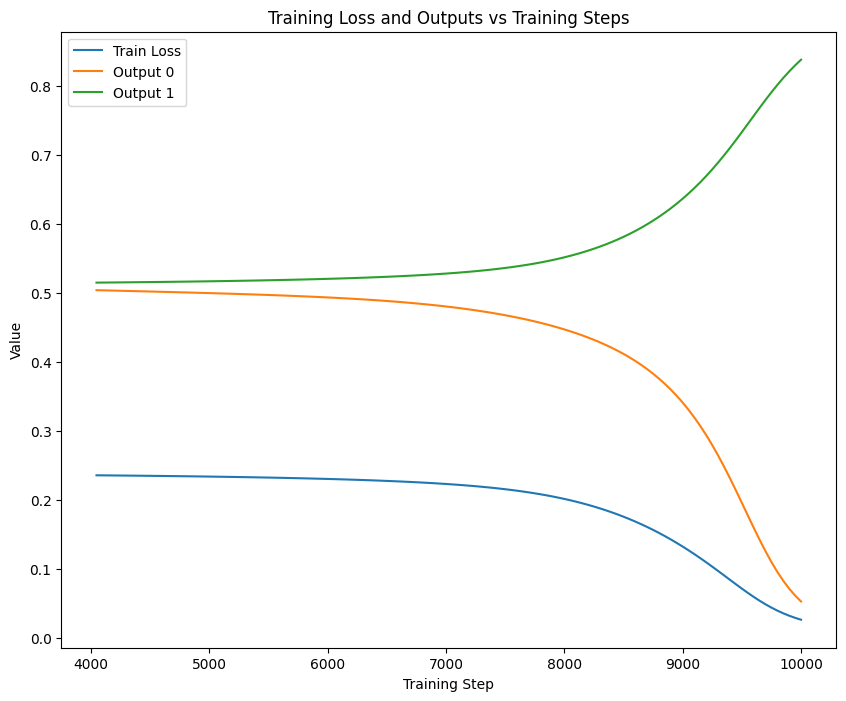

In [40]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import glob

log_dirs = sorted(glob.glob('lightning_logs/version_*'), key=lambda x: int(x.split('_')[-1]))
if log_dirs:
    log_dir = log_dirs[-1]
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Extract scalar data
    steps = []
    train_loss = []
    out_0 = []
    out_1 = []

    if 'train_loss' in ea.Tags()['scalars']:
        for e in ea.Scalars('train_loss'):
            steps.append(e.step)
            train_loss.append(e.value)
    if 'out_0' in ea.Tags()['scalars']:
        out_0 = [e.value for e in ea.Scalars('out_0')]
    if 'out_1' in ea.Tags()['scalars']:
        out_1 = [e.value for e in ea.Scalars('out_1')]

    plt.figure(figsize=(10,8))
    plt.plot(steps, train_loss, label='Train Loss')
    if out_0:
        plt.plot(steps[:len(out_0)], out_0, label='Output 0')
    if out_1:
        plt.plot(steps[:len(out_1)], out_1, label='Output 1')
    plt.xlabel('Training Step')
    plt.ylabel('Value')
    plt.title('Training Loss and Outputs vs Training Steps')
    plt.legend()
    plt.show()
else:
    print("No lightning_logs found. Please run training first.")

In [41]:
# Find the ModelCheckpoint callback and get the best model path
checkpoint_callback = None
for cb in trainer.callbacks:
	if hasattr(cb, "best_model_path"):
		checkpoint_callback = cb
		break

if checkpoint_callback is not None:
	path_to_best_checkpoint = checkpoint_callback.best_model_path
else:
	path_to_best_checkpoint = None  # or raise an error if you want

trainer = L.Trainer(max_epochs=7000)
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=path_to_best_checkpoint)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /Users/bishwashchaudhari/quests/lightning_logs/version_7/checkpoints/epoch=4999-step=10000.ckpt
/Users/bishwashchaudhari/quests/venv/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/Users/bishwashchaudhari/quests/lightning_logs/version_7/checkpoints' to '/Users/bishwashchaudhari/quests/lightning_logs/version_8/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 12     | n/a 
-

Epoch 6999: 100%|██████████| 2/2 [00:00<00:00, 83.94it/s, v_num=8] 

`Trainer.fit` stopped: `max_epochs=7000` reached.


Epoch 6999: 100%|██████████| 2/2 [00:00<00:00, 62.15it/s, v_num=8]


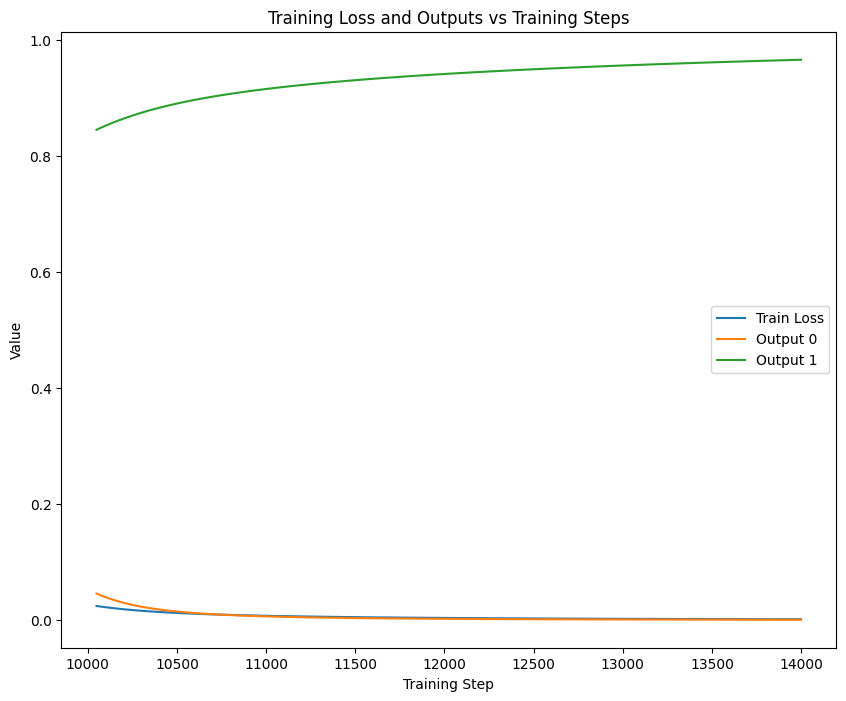

In [42]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import glob

log_dirs = sorted(glob.glob('lightning_logs/version_*'), key=lambda x: int(x.split('_')[-1]))
if log_dirs:
    log_dir = log_dirs[-1]
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Extract scalar data
    steps = []
    train_loss = []
    out_0 = []
    out_1 = []

    if 'train_loss' in ea.Tags()['scalars']:
        for e in ea.Scalars('train_loss'):
            steps.append(e.step)
            train_loss.append(e.value)
    if 'out_0' in ea.Tags()['scalars']:
        out_0 = [e.value for e in ea.Scalars('out_0')]
    if 'out_1' in ea.Tags()['scalars']:
        out_1 = [e.value for e in ea.Scalars('out_1')]

    plt.figure(figsize=(10,8))
    plt.plot(steps, train_loss, label='Train Loss')
    if out_0:
        plt.plot(steps[:len(out_0)], out_0, label='Output 0')
    if out_1:
        plt.plot(steps[:len(out_1)], out_1, label='Output 1')
    plt.xlabel('Training Step')
    plt.ylabel('Value')
    plt.title('Training Loss and Outputs vs Training Steps')
    plt.legend()
    plt.show()
else:
    print("No lightning_logs found. Please run training first.")

In [43]:
print("\n Let's compare the observed and predicted values...")
print(f"\n Company A: observed = 0 ,predicted = {model(torch.tensor([0.,.5,.25,1.]).detach())}")
print(f"\n Company B: observed = 0 ,predicted = {model(torch.tensor([1.,.5,.25,1.]).detach())}")


 Let's compare the observed and predicted values...

 Company A: observed = 0 ,predicted = 0.00039944570744410157

 Company B: observed = 0 ,predicted = 0.9656085968017578


## using 
`nn.LSTM`

In [44]:
class LightningLSTM(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=1)
        
    def forward(self,input):
        input_trans= input.view(len(input),1)
        lstm_out ,temp = self.lstm(input_trans)
        
        prediction = lstm_out[-1] 
        return prediction
    
    def configure_optimizers(self,batch,bacth_idx):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self, batch, batch_idx):
        input_i,label_i = batch
        output_i = self.forward(input_i[0])
        loss = (output_i -label_i)**2
        
        self.log("train_loss",loss)
        
        if(label_i == 0):
            self.log('out_0',output_i)
        else:
            self.log("out_1",output_i)
        return loss

In [45]:
model1 = LightningLSTM()

In [46]:
print("\n Let's compare the observed and predicted values using LightningLSTM")
print(f"\n Company A: observed = 0 ,predicted = {model(torch.tensor([0.,.5,.25,1.]).detach())}")
print(f"\n Company B: observed = 0 ,predicted = {model(torch.tensor([1.,.5,.25,1.]).detach())}")


 Let's compare the observed and predicted values using LightningLSTM

 Company A: observed = 0 ,predicted = 0.00039944570744410157

 Company B: observed = 0 ,predicted = 0.9656085968017578


In [47]:
trainer = L.Trainer(max_epochs=300,log_every_n_steps=2)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(model,train_dataloaders=dataloader)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 12     | n/a 
---------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/bishwashchaudhari/quests/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00, 82.10it/s, v_num=9]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00, 58.56it/s, v_num=9]


In [49]:
print("\n Let's compare the observed and predicted values using LightningLSTM")
print(f"\n Company A: observed = 0 ,predicted = {model(torch.tensor([0.,.5,.25,1.]).detach())}")
print(f"\n Company B: observed = 0 ,predicted = {model(torch.tensor([1.,.5,.25,1.]).detach())}")


 Let's compare the observed and predicted values using LightningLSTM

 Company A: observed = 0 ,predicted = 2.2013275156496093e-05

 Company B: observed = 0 ,predicted = 0.9853187799453735


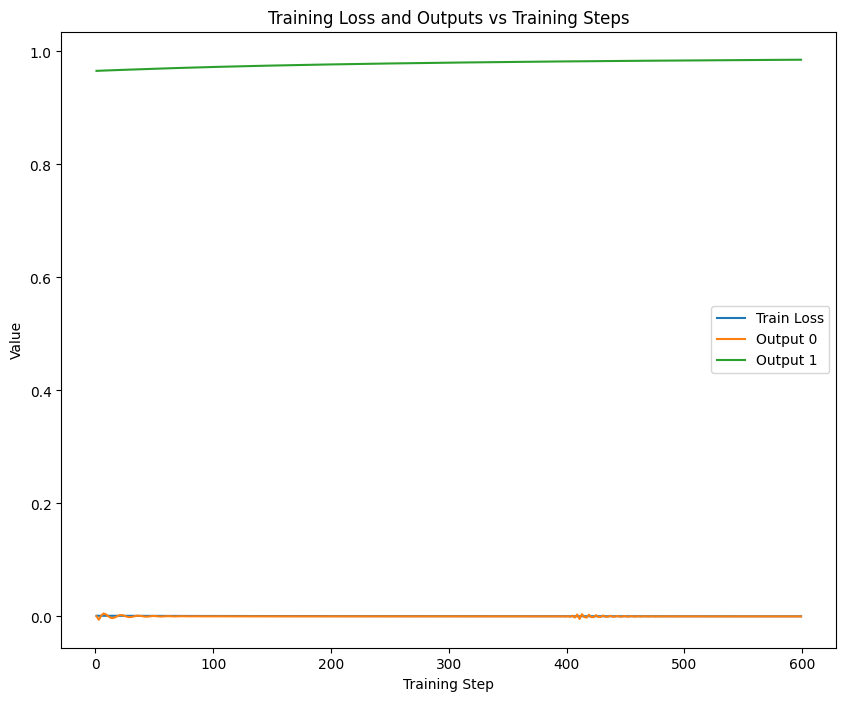

In [50]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import glob

log_dirs = sorted(glob.glob('lightning_logs/version_*'), key=lambda x: int(x.split('_')[-1]))
if log_dirs:
    log_dir = log_dirs[-1]
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Extract scalar data
    steps = []
    train_loss = []
    out_0 = []
    out_1 = []

    if 'train_loss' in ea.Tags()['scalars']:
        for e in ea.Scalars('train_loss'):
            steps.append(e.step)
            train_loss.append(e.value)
    if 'out_0' in ea.Tags()['scalars']:
        out_0 = [e.value for e in ea.Scalars('out_0')]
    if 'out_1' in ea.Tags()['scalars']:
        out_1 = [e.value for e in ea.Scalars('out_1')]

    plt.figure(figsize=(10,8))
    plt.plot(steps, train_loss, label='Train Loss')
    if out_0:
        plt.plot(steps[:len(out_0)], out_0, label='Output 0')
    if out_1:
        plt.plot(steps[:len(out_1)], out_1, label='Output 1')
    plt.xlabel('Training Step')
    plt.ylabel('Value')
    plt.title('Training Loss and Outputs vs Training Steps')
    plt.legend()
    plt.show()
else:
    print("No lightning_logs found. Please run training first.")